In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils import plot_confusion_matrix

In [5]:
filename = 'output/COLRECT_pivoted.pickle'

df_filtered = pd.read_pickle(filename)

df_filtered.head()

,PUBCSNUM,AGE_DX,MDXRECMP,YEAR_DX,REC_NO,SRV_TIME_MON,MALIGCOUNT,BENBORDCOUNT,REG__0000001501,REG__0000001502,...,ODTHCLASS__0,ODTHCLASS__1,ODTHCLASS__8,ODTHCLASS__9,INTPRIM__0,INTPRIM__1,INTPRIM__9,CSSCHEMA__25,CSSCHEMA__26,CSSCHEMA__36
9,07000085,077,02,2007,02,0047,04,00,0,1,...,0,0,0,1,0,1,0,0,1,0
32,07000321,086,09,2012,01,0039,02,00,0,1,...,0,0,0,1,0,1,0,1,0,0
44,07000411,088,07,2006,01,0038,02,00,0,1,...,0,0,0,1,0,1,0,1,0,0
57,07000510,082,05,2011,02,0016,03,00,0,1,...,0,0,0,1,0,1,0,1,0,0
73,07000635,083,05,2010,01,0067,02,00,0,1,...,0,0,0,1,0,1,0,1,0,0


In [6]:
# Prepare training

x_df = df_filtered.drop(columns=['PUBCSNUM', 'SRV_TIME_MON'])
X = x_df.values.astype(np.float32)
y_cont = df_filtered.SRV_TIME_MON.values.astype(np.float32)
y = np.where(y_cont > 60, 1, 0)

print(f'Feature shape: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Feature shape: (277984, 1245)


In [7]:
# Feature selection (Step 1. RF training)

print('Start training random forest...')
model_for_fs = RandomForestClassifier(n_jobs=8, random_state=42)
model_for_fs.fit(X_train, y_train)

Start training random forest...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [8]:
# Feature selection (Step 2. create feature selector)

feature_selector = SelectFromModel(model_for_fs, prefit=True)

feature_selected_column_names = x_df.columns[feature_selector.get_support()].values

with open('feature_selected_column_info.txt', 'w') as f:
    f.write(' '.join(feature_selected_column_names))
    
with open('feature_selected_column_info_simple.txt', 'w') as f:
    simple = []
    for name in feature_selected_column_names:
        simple.append(name.split('_')[0])
    simple = list(set(simple))
    f.write(' '.join(simple))
    

In [9]:
# Feature selection (Step 2. transform Xs)

X_train_fs = feature_selector.transform(X_train)
X_test_fs = feature_selector.transform(X_test)

print(f'Number of selected features: {X_train_fs.shape[1]}')

Number of selected features: 138


In [10]:
# Scaling

scalar = MinMaxScaler()
scalar.fit(X_train_fs)

X_train_scaled = scalar.transform(X_train_fs)
X_test_scaled = scalar.transform(X_test_fs)

joblib.dump(scalar, 'scalar.pickle')

['scalar.pickle']

In [11]:
# Logistic Regression

print('Start training logistic regression...')
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)

print('Saving logistic regression model...')
joblib.dump(model_lr, 'model_lr.pickle')

Start training logistic regression...
Saving logistic regression model...


['model_lr.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.95      0.94    131888
     > 5yrs       0.89      0.85      0.87     62700

avg / total       0.91      0.92      0.91    194588

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.95      0.94     56342
     > 5yrs       0.89      0.84      0.86     27054

avg / total       0.91      0.91      0.91     83396

Confusion matrix, without normalization


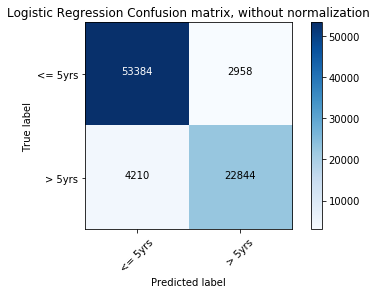

Normalized confusion matrix


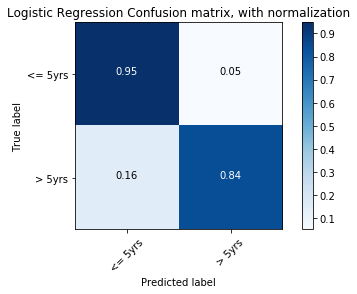

In [12]:
target_names = ['<= 5yrs', '> 5yrs']

def eval(model, name, Xtr=X_train_scaled, Xts=X_test_scaled):
    print('Training set evaluation')
    y_train_pred = model.predict(Xtr)
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    print('Test set evaluation')
    y_test_pred = model.predict(Xts)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                          title=f'{name} Confusion matrix, without normalization')
    plt.show()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title=f'{name} Confusion matrix, with normalization')
    plt.show()
    
eval(model_lr, 'Logistic Regression')

In [13]:
# Random Forest

print('Start training random forest...')
model_rf = RandomForestClassifier(n_estimators=20,
                                  n_jobs=8, 
                                  random_state=42)
model_rf.fit(X_train_scaled, y_train)

print('Saving random forest model...')
joblib.dump(model_rf, 'model_rf.pickle')

Start training random forest...
Saving random forest model...


['model_rf.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       1.00      1.00      1.00    131888
     > 5yrs       1.00      0.99      1.00     62700

avg / total       1.00      1.00      1.00    194588

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.97      0.95     56342
     > 5yrs       0.93      0.84      0.88     27054

avg / total       0.93      0.93      0.93     83396

Confusion matrix, without normalization


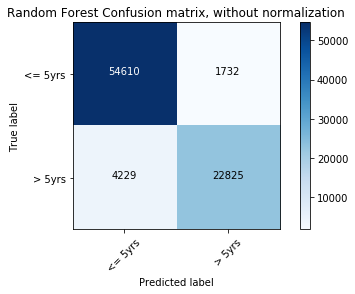

Normalized confusion matrix


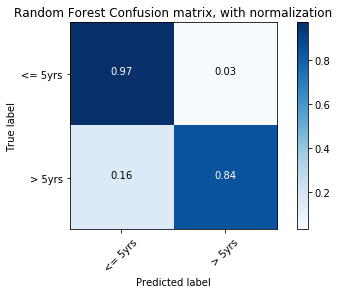

In [14]:
eval(model_rf, 'Random Forest')

In [15]:
# Linear SVM

print('Start training linear SVM...')
model_lsvm = LinearSVC(random_state=42)
model_lsvm.fit(X_train_scaled, y_train)

print('Saving Linear SVM model...')
joblib.dump(model_lsvm, 'model_lsvm.pickle')

Start training linear SVM...
Saving Linear SVM model...


['model_lsvm.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.95      0.94    131888
     > 5yrs       0.89      0.84      0.86     62700

avg / total       0.91      0.91      0.91    194588

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.95      0.94     56342
     > 5yrs       0.89      0.84      0.86     27054

avg / total       0.91      0.91      0.91     83396

Confusion matrix, without normalization


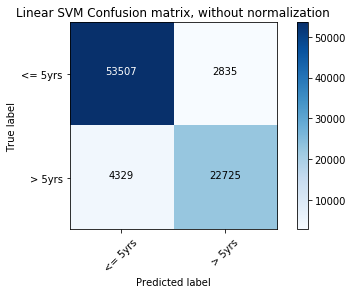

Normalized confusion matrix


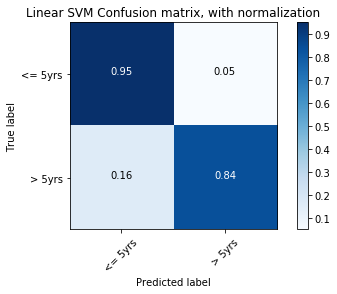

In [16]:
eval(model_lsvm, 'Linear SVM')

In [ ]:
# SVM

print('Start training SVM...')
model_svm = SVC(random_state=42)
model_svm.fit(X_train_scaled, y_train)

print('Saving SVM model...')
joblib.dump(model_svm, 'model_svm.pickle')

Start training SVM...


In [ ]:
eval(model_svm, 'SVM')

In [17]:
# MLP

print('Start training MLP...')
model_mlp = MLPClassifier(hidden_layer_sizes=(100,),
                          random_state=42,
                          verbose=True)
model_mlp.fit(X_train_scaled, y_train)

print('Saving MLP model...')
joblib.dump(model_mlp, 'model_mlp.pickle')

Start training MLP...
Iteration 1, loss = 0.29005617
Iteration 2, loss = 0.21089235
Iteration 3, loss = 0.19457878
Iteration 4, loss = 0.18402263
Iteration 5, loss = 0.17749108
Iteration 6, loss = 0.17294358
Iteration 7, loss = 0.16942252
Iteration 8, loss = 0.16719363
Iteration 9, loss = 0.16526217
Iteration 10, loss = 0.16363974
Iteration 11, loss = 0.16285960
Iteration 12, loss = 0.16175531
Iteration 13, loss = 0.16090273
Iteration 14, loss = 0.15984401
Iteration 15, loss = 0.15894781
Iteration 16, loss = 0.15837302
Iteration 17, loss = 0.15776532
Iteration 18, loss = 0.15705962
Iteration 19, loss = 0.15630003
Iteration 20, loss = 0.15586499
Iteration 21, loss = 0.15525161
Iteration 22, loss = 0.15465811
Iteration 23, loss = 0.15396281
Iteration 24, loss = 0.15353604
Iteration 25, loss = 0.15339271
Iteration 26, loss = 0.15272013
Iteration 27, loss = 0.15190412
Iteration 28, loss = 0.15161194
Iteration 29, loss = 0.15119556
Iteration 30, loss = 0.15053063
Iteration 31, loss = 0.1503

['model_mlp.pickle']

Training set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.95      0.97      0.96    131888
     > 5yrs       0.94      0.90      0.92     62700

avg / total       0.95      0.95      0.95    194588

Test set evaluation
             precision    recall  f1-score   support

    <= 5yrs       0.93      0.95      0.94     56342
     > 5yrs       0.90      0.86      0.88     27054

avg / total       0.92      0.92      0.92     83396

Confusion matrix, without normalization


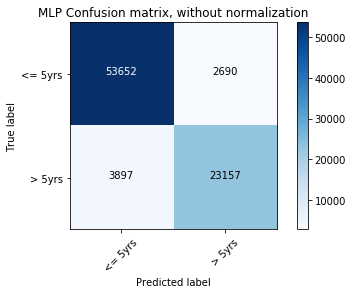

Normalized confusion matrix


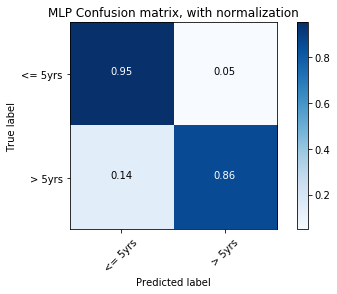

In [18]:
eval(model_mlp, 'MLP', X_train_scaled, X_test_scaled)